In [15]:
!pip install keras==2.1.5

     |████████████████████████████████| 337kB 5.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [16]:
!pip install tensorflow==1.14.0
import tensorflow as tf

     |████████████████████████████████| 109.3MB 76kB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 3.2MB 19.6MB/s 
     |████████████████████████████████| 491kB 30.8MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import matplotlib.image
import glob
import scipy.misc
from PIL import Image
#import imgaug 
from imgaug import augmenters as iaa

In [2]:
cd /content/drive/MyDrive/Mammographic

/content/drive/MyDrive/Mammographic


In [3]:
# Root directory of the project
ROOT_DIR = os.getcwd()
ROOT_DIR = ROOT_DIR+"/Mask_r_cnn"

MAMOGRAM_IMAGE_DIR = "/scans/pseudo_color_image/" #Path of the mammograms
MAMOGRAM_MASK_DIR = "/scans/preprocessed_mask/"# Path of the ground truth masks


# Import Mask RCNN
sys.path.append(ROOT_DIR) # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_balloon.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join("/content/drive/MyDrive/Mammographic", "logs")#Log directory for saving the weights
DEMO_SAVE_DIR = "/scans/seg_mask/"# path to save the segmentation masks


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
print(ROOT_DIR + COCO_WEIGHTS_PATH)

/content/drive/My Drive/Mammographic/Mask_r_cnn/content/drive/My Drive/Mammographic/Mask_r_cnn/mask_rcnn_balloon.h5


In [12]:
############################################################
#  Configurations
############################################################


class MamogramConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mamogram"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + lesion

    # Number of training steps per epoch,set to the number of training data here
    STEPS_PER_EPOCH = 100

    # Number of validation steps after each round of training
    VALIDATION_STEPS = 10
    # Resize mode: "none" or "square"

    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Skip detections with < DETECTION_MIN_CONFIDENCE
    DETECTION_MIN_CONFIDENCE = 0.965 # alter this during testing to generate different TPR at different FPI
    # 0.7 0.75 0.8 0.85 0.9 

config = MamogramConfig()
#config.display()

In [ ]:
print(ROOT_DIR + MAMOGRAM_MASK_DIR)

/content/drive/MyDrive/Mammographic/Mask_r_cnn/scans/preprocessed_mask/


In [ ]:
print(ROOT_DIR + MAMOGRAM_IMAGE_DIR + "train" +"/"+ '22580192_5530d5782fc89dd7_MG_R_CC_ANON.png')

/content/drive/My Drive/Mammographic/Mask_r_cnn/scans/pseudo_color_image/train/22580192_5530d5782fc89dd7_MG_R_CC_ANON.png


In [ ]:
print(ROOT_DIR + MAMOGRAM_MASK_DIR + "train" +"/"+ '22580192_5530d5782fc89dd7_MG_R_CC_ANON.png' + "*")

/content/drive/My Drive/Mammographic/Mask_r_cnn/scans/preprocessed_mask/train/22580192_5530d5782fc89dd7_MG_R_CC_ANON.png*


In [5]:
############################################################
#  Dataset
############################################################

class MamogramDataset(utils.Dataset):

    def load_mamogram(self, subset):
        """This method loads the actual image
        subset is either "train" or "val" depending on whether the image is part of the training or validation datasets 
        """
        # Add classes. We have only one class to add.
        # These are the things that will be segmented
        self.add_class("mamogram", 1, "lesion")

        # Train or validation dataset?

        #list all the files in the directory with the mamogram images
        files = os.listdir(ROOT_DIR + MAMOGRAM_IMAGE_DIR + subset + "/")
        
        for fname in files:            
            self.add_image("mamogram", image_id=fname, 
                           path=ROOT_DIR + MAMOGRAM_IMAGE_DIR + subset +"/"+ fname, subset=subset, fname=fname)


    def load_mask(self, image_id):
        """load the instance masks for an image.
        Returns:
        a tuple containing:
        masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        use dtype=np.int32
        """
        image_info = self.image_info[image_id]
        info = self.image_info[image_id]
        fname = info['fname']
        #count=len(fname)
       

        #files = glob.glob(ROOT_DIR + MAMOGRAM_MASK_DIR + info['subset']+"/" + fname[0:-4] + "*")
        #files=ROOT_DIR + MAMOGRAM_MASK_DIR + "train" +"/"+ fname
        files = glob.glob(ROOT_DIR + MAMOGRAM_MASK_DIR + info['subset']+"/" + fname[0:-4] + "*")
        #print(files)
        

        masks = []
        for i in range(0, len(files)):
            #print(i)
            data = skimage.io.imread(files[i])
            
            if data.ndim != 1:
                data = skimage.color.rgb2gray(data)
          
            singleMask = data
            if i == 0:
                masks = np.zeros((singleMask.shape[0], singleMask.shape[1], len(files)))
            masks[:,:,i] = singleMask
            #masks=np.array(masks)
            

        instanceMaskMap = np.array(np.ones([masks.shape[-1]], dtype=np.int32))
        #instanceMaskMap = [masks.shape[-1]]
        print("mask Shape")
        print(masks.shape)
        return (masks.astype(np.bool), instanceMaskMap)


        #class_ids = np.array([self.class_names.index(s[0]) for s in fname])
        #return mask.astype(np.bool), class_ids.astype(np.int32)
         #this is VERY important: array of class ids in the order that they appear in bigdata
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1

In [14]:
############################################################
#  Dataset
############################################################

class MamogramDataset(utils.Dataset):

    def load_mamogram(self, subset):
        """This method loads the actual image
        subset is either "train" or "val" depending on whether the image is part of the training or validation datasets 
        """
        # Add classes. We have only one class to add.
        # These are the things that will be segmented
        self.add_class("mamogram", 1, "lesion")

        # Train or validation dataset?

        #list all the files in the directory with the mamogram images
        files = os.listdir(ROOT_DIR + MAMOGRAM_IMAGE_DIR + subset + "/")
        
        for fname in files:            
            self.add_image("mamogram", image_id=fname, 
                           path=ROOT_DIR + MAMOGRAM_IMAGE_DIR + subset +"/"+ fname, subset=subset, fname=fname)


    def load_mask(self, image_id):
        """load the instance masks for an image.
        Returns:
        a tuple containing:
        masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        use dtype=np.int32
        """
        image_info = self.image_info[image_id]
        info = self.image_info[image_id]
        fname = info['fname']
       
        files = glob.glob(ROOT_DIR + MAMOGRAM_MASK_DIR + info['subset']+"/" + fname[0:-4] + "*")
        

        masks = []
        for i in range(0, len(files)):
            #print(i)
            data = skimage.io.imread(files[i])
            
            if data.ndim != 1:
                data = skimage.color.rgb2gray(data)
          
            singleMask = data
            if i == 0:
                masks = np.zeros((singleMask.shape[0], singleMask.shape[1], len(files)))
            masks[:,:,i] = singleMask

        instanceMaskMap = np.array(np.ones([masks.shape[-1]], dtype=np.int32))
        print("mask Shape")
        print(masks.shape)
        
        return (masks.astype(np.bool), instanceMaskMap)


        #class_ids = np.array([self.class_names.index(s[0]) for s in fname])
        #return mask.astype(np.bool), class_ids.astype(np.int32)
         #this is VERY important: array of class ids in the order that they appear in bigdata
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
		Taken from utils.py, any refinements we need can be done here
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]

        print("image Shape")
        print(image.shape)
        return image

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        return info["path"]

In [15]:
 # Training dataset.
dataset_train = MamogramDataset()
dataset_train.load_mamogram("train")
dataset_train.prepare()

# Validation dataset
dataset_val = MamogramDataset()
dataset_val.load_mamogram("val")
dataset_val.prepare()

In [16]:
print(dataset_train.class_names)

['BG', 'lesion']


In [17]:
model = modellib.MaskRCNN(mode="training", config=config,model_dir=DEFAULT_LOGS_DIR)
    

In [8]:
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

image Shape
(681, 681, 3)
mask Shape
(2718, 2718, 1)
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 11   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  2   0   1]
  [ 17   0  12]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55   0  34]
  [ 70   0  39]
  [ 83   0  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113   3  87]
  [117   2  89]
  [130   2  95]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 78   0  44]
  [ 85   0  50]
  [ 93   0  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18   0   0]
  [ 21   0   0]
  [ 36   0   0]]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [

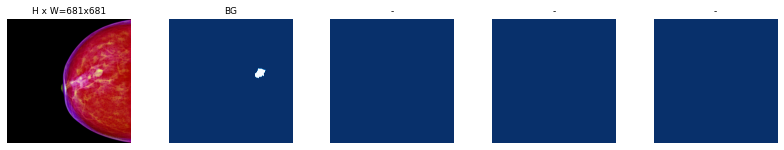

In [18]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 1)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, num_ids = dataset.load_mask(image_id)
    print(image,masks,num_ids)
    visualize.display_top_masks(image, masks, image_id, dataset.class_names)

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 11   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  2   0   1]
  [ 17   0  12]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55   0  34]
  [ 70   0  39]
  [ 83   0  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113   3  87]
  [117   2  89]
  [130   2  95]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 78   0  44]
  [ 85   0  50]
  [ 93   0  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18   0   0]
  [ 21   0   0]
  [ 36   0   0]]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [F

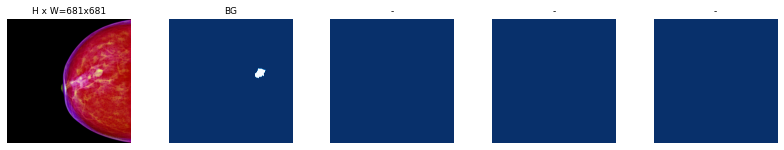

In [11]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 1)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, num_ids = dataset.load_mask(image_id)
    print(image,masks,num_ids)
    visualize.display_top_masks(image, masks, image_id, dataset.class_names)

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 11   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  2   0   1]
  [ 17   0  12]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55   0  34]
  [ 70   0  39]
  [ 83   0  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113   3  87]
  [117   2  89]
  [130   2  95]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 78   0  44]
  [ 85   0  50]
  [ 93   0  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18   0   0]
  [ 21   0   0]
  [ 36   0   0]]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [F

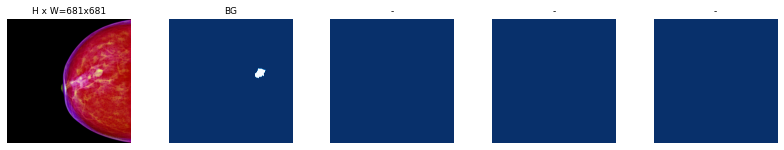

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 11   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  2   0   1]
  [ 17   0  12]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55   0  34]
  [ 70   0  39]
  [ 83   0  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113   3  87]
  [117   2  89]
  [130   2  95]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 78   0  44]
  [ 85   0  50]
  [ 93   0  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18   0   0]
  [ 21   0   0]
  [ 36   0   0]]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [F

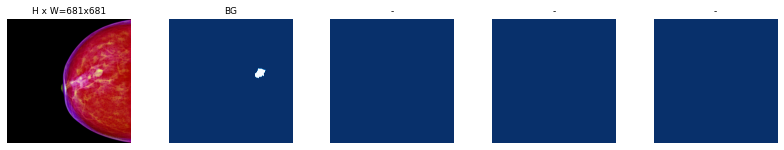

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 11   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  2   0   1]
  [ 17   0  12]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55   0  34]
  [ 70   0  39]
  [ 83   0  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113   3  87]
  [117   2  89]
  [130   2  95]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 78   0  44]
  [ 85   0  50]
  [ 93   0  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18   0   0]
  [ 21   0   0]
  [ 36   0   0]]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [F

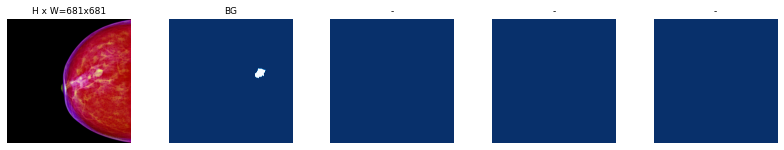

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 11   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  2   0   1]
  [ 17   0  12]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55   0  34]
  [ 70   0  39]
  [ 83   0  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113   3  87]
  [117   2  89]
  [130   2  95]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 78   0  44]
  [ 85   0  50]
  [ 93   0  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18   0   0]
  [ 21   0   0]
  [ 36   0   0]]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [F

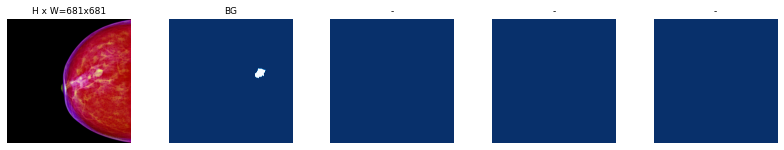

In [10]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, num_ids = dataset.load_mask(image_id)
    print(image,masks,num_ids)
    visualize.display_top_masks(image, masks, image_id, dataset.class_names)

In [ ]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, num_ids = dataset.load_mask(image_id)
    print(image,masks,num_ids)
    #visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 11   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  2   0   1]
  [ 17   0  12]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55   0  34]
  [ 70   0  39]
  [ 83   0  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113   3  87]
  [117   2  89]
  [130   2  95]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 78   0  44]
  [ 85   0  50]
  [ 93   0  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18   0   0]
  [ 21   0   0]
  [ 36   0   0]]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [F

In [ ]:
# Load and display random samples
dataset = dataset_val
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, num_ids = dataset.load_mask(image_id)
    print(image,masks,num_ids)
    #visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 11   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  2   0   1]
  [ 17   0  12]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55   0  34]
  [ 70   0  39]
  [ 83   0  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113   3  87]
  [117   2  89]
  [130   2  95]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 78   0  44]
  [ 85   0  50]
  [ 93   0  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18   0   0]
  [ 21   0   0]
  [ 36   0   0]]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [F

In [ ]:
!pip install keras==2.1.5

     |████████████████████████████████| 337kB 24.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
!pip install tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 109.3MB 50kB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 3.2MB 48.8MB/s 
     |████████████████████████████████| 491kB 51.1MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


2.4.1
